# ImageInsight  

ImageInsight is an automated image classification pipeline designed to demonstrate the end-to-end capabilities of a machine learning workflow. This project leverages a pre-trained VGG16 model to classify images of cats and dogs, showcasing the entire process from data ingestion and preprocessing to model training and evaluation. The primary goal is to illustrate the practical application of transfer learning in a simplified and resource-efficient manner, suitable for a quick demo in environments like Google Colab. This project highlights key MLOps principles, ensuring a streamlined and effective pipeline for image classification tasks.

### Project Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Data Ingestion

In [2]:
# Download and extract dataset
import zipfile
import os
import urllib.request

url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(url, 'cats_and_dogs_filtered.zip')

with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall()

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### Data Preprocessing


In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Model Building and Training

In [4]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)   #512
x = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, x)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=50, #100
    epochs=5,           #20
    validation_data=validation_generator,
    validation_steps=25 #50
)

58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/5
50/50 [==============================] - 21s 284ms/step - loss: 0.6753 - accuracy: 0.6680 - val_loss: 0.4037 - val_accuracy: 0.8080
Epoch 2/5
50/50 [==============================] - 11s 228ms/step - loss: 0.4315 - accuracy: 0.7820 - val_loss: 0.3662 - val_accuracy: 0.8120
Epoch 3/5
50/50 [==============================] - 8s 166ms/step - loss: 0.3881 - accuracy: 0.8100 - val_loss: 0.3350 - val_accuracy: 0.8400
Epoch 4/5
50/50 [==============================] - 9s 171ms/step - loss: 0.3679 - accuracy: 0.8390 - val_loss: 0.2890 - val_accuracy: 0.8700
Epoch 5/5
50/50 [==============================] - 9s 183ms/step - loss: 0.3675 - accuracy: 0.8340 - val_loss: 0.3020 - val_accuracy: 0.8760


### Model Evaluation

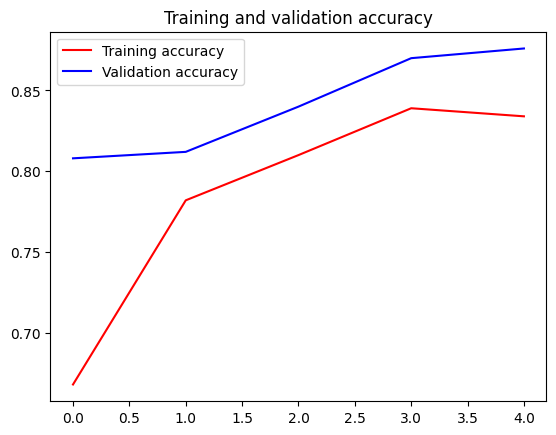

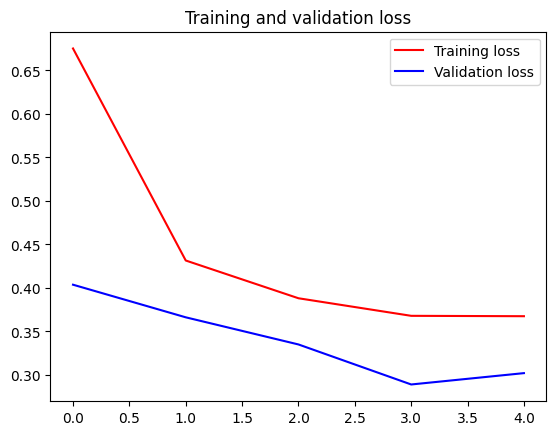

In [5]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Model Testing and Analysis

50/50 [==============================] - 5s 69ms/step
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

        Cats       0.51      0.50      0.51       500
        Dogs       0.51      0.52      0.52       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



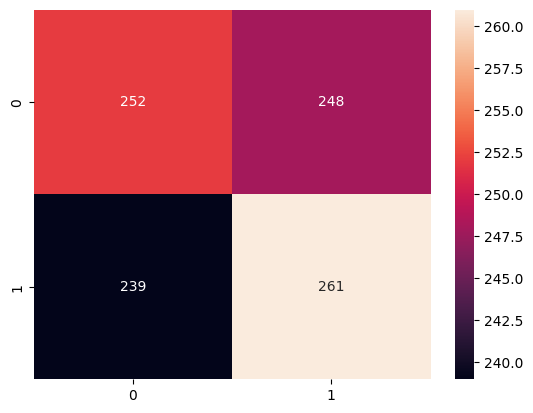

In [6]:
# Evaluate the model on the validation data
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples//validation_generator.batch_size, verbose=1)
y_pred = np.where(predictions > 0.5, 1, 0)

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=['Cats', 'Dogs']))
